# Lab 6

### Secret Markdown Function

In [31]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

### Connect Database

In [32]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

### Install Python Packages

In [33]:
! pip install jupyter-ai-magics[all] -q

In [34]:
import warnings
warnings.simplefilter('ignore')

### Store OpenAI Key

In [35]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

### Load the Jupyter AI Magic Commands¶

In [36]:
%load_ext jupyter_ai_magics

The jupyter_ai_magics extension is already loaded. To reload it, use:
  %reload_ext jupyter_ai_magics


### Population Growth Rate

In [37]:
sql = """
      SELECT
    year,
    pop AS current_year_population,
    LAG(pop, 1) OVER (ORDER BY year) AS previous_year_population,
    (pop - LAG(pop, 1) OVER (ORDER BY year)) * 100.0 / LAG(pop, 1) OVER (ORDER BY year) AS growth_rate_percent
FROM
    population
WHERE
    fips = '48'
ORDER BY
    year;
     """

In [38]:
import pandas as pd

q1_df = pd.read_sql(sql, con=conn)
q1_df.head() #show the top 5 rows

,year,current_year_population,previous_year_population,growth_rate_percent
0,2005,22270165,NaN,NaN
1,2006,23507783,22270165.0,5.557292
2,2007,23904380,23507783.0,1.687088
3,2008,24326974,23904380.0,1.767852
4,2009,24782302,24326974.0,1.871700


In [39]:
%%ai gpt4 -f code
Calculate the population growth rate with the data provided in {q1_df}, use the q1_df directly, and visualize the result on a line chart

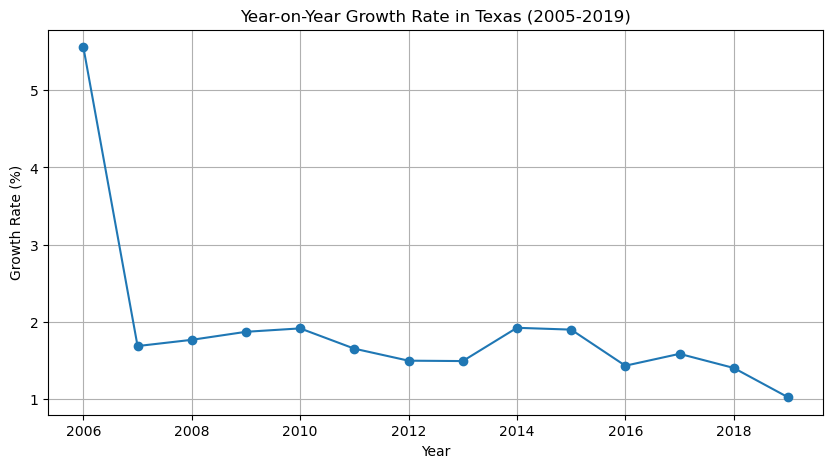

In [40]:
import matplotlib.pyplot as plt 

#Assuming the provided data is stored in a DataFrame named tx_df
q1_df = pd.DataFrame(
    data={
        'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
        'current_year_population': [22270165, 23507783, 23904380, 24326974, 24782302, 25257114, 25674681, 26059203, 26448193, 26956958, 27469114, 27862596, 28304596, 28701845, 28995881],
        'previous_year_population': [None, 22270165, 23507783, 23904380, 24326974, 24782302, 25257114, 25674681, 26059203, 26448193, 26956958, 27469114, 27862596, 28304596, 28701845], 
        'growth_rate_percent': [None, 5.557292, 1.687088, 1.767852, 1.8717, 1.915932, 1.653265, 1.49767, 1.492716, 1.923629, 1.899903, 1.432452, 1.586356, 1.403479, 1.02445],
    }
)

# Set the year as index to facilitate visualisation
q1_df.set_index('year', inplace=True)

# Create a line chart to visualize the growth rate
plt.figure(figsize=(10,5))
plt.plot(tx_df['growth_rate_percent'], marker='o')
plt.title('Year-on-Year Growth Rate in Texas (2005-2019)')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()

##### Over time, the Growth Rate has decreased, staying under 2% for 13 years 

### Income and Population Relationship

In [42]:
sql = """
      SELECT
    t1.year,
    t1.income,
    t2.pop
FROM
    income AS t1
JOIN
    population AS t2
    ON t1.fips = t2.fips AND t1.year = t2.year
JOIN
    name AS t3
    ON t1.fips = t3.fips
WHERE
    t3.name = 'Texas' -- Filter by state name (e.g., Texas)
ORDER BY
    t1.year
     """

In [43]:
q2_df = pd.read_sql(sql, con=conn)
q2_df.head() #show the top 5 rows

,year,income,pop
0,2005,42139,22270165
1,2006,44922,23507783
2,2007,47548,23904380
3,2008,50043,24326974
4,2009,48259,24782302


In [52]:
%%ai gpt4 -f code
Use the data provided in {q2_df} to visualize the result a dual-axis chart with X-axis = year, Left Y-axis = population (line), Right Y-axis = median income (bar or line, different color), and the state (Texas) in the title

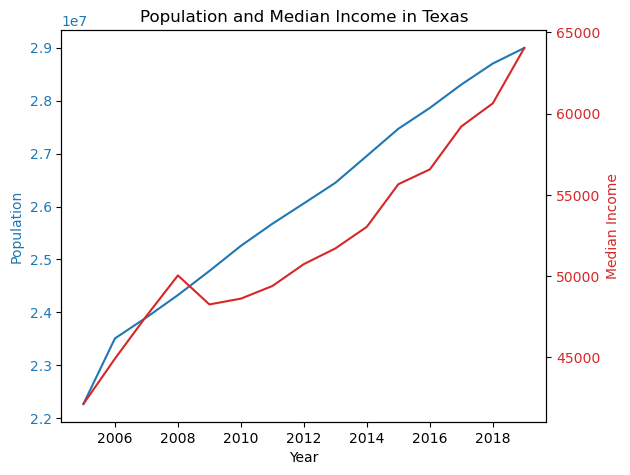

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'income': [42139, 44922, 47548, 50043, 48259, 48615, 49392, 50740, 51704, 53035, 55653, 56565, 59206, 60629, 64034],
    'pop': [22270165, 23507783, 23904380, 24326974, 24782302, 25257114, 25674681, 26059203, 26448193, 26956958, 27469114, 27862596, 28304596, 28701845, 28995881]
}
df = pd.DataFrame(data)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(df.year, df['pop'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Median Income', color=color)
ax2.plot(df.year, df['income'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Population and Median Income in Texas')
plt.show()

##### Both Income and Population have positively increased over time; however, median income trends lower than population.

### Population vs Income Growth Rate

In [54]:
sql = """
      SELECT
    year,
    -- 1. Income Growth Rate: (Current Income - Previous Income) / Previous Income * 100
    (income - LAG(income, 1) OVER (ORDER BY year)) * 100.0 / LAG(income, 1) OVER (ORDER BY year) AS income_growth_percent,
    
    -- 2. Population Growth Rate: (Current Pop - Previous Pop) / Previous Pop * 100
    (pop - LAG(pop, 1) OVER (ORDER BY year)) * 100.0 / LAG(pop, 1) OVER (ORDER BY year) AS pop_growth_percent
FROM
    (
        -- Subquery (Combined_Data): Joins income and population for Texas
        SELECT
            t1.year,
            t1.income,
            t2.pop
        FROM
            income AS t1
        JOIN
            population AS t2 ON t1.fips = t2.fips AND t1.year = t2.year
        JOIN
            name AS t3 ON t1.fips = t3.fips -- Join to name to filter by state name
        WHERE
            t3.name = 'Texas'
    ) AS combined_data
ORDER BY
    year;
     """

In [55]:
q3_df = pd.read_sql(sql, con=conn)
q3_df.head() #show the top 5 rows

,year,income_growth_percent,pop_growth_percent
0,2005,NaN,NaN
1,2006,6.604333,5.557292
2,2007,5.845688,1.687088
3,2008,5.247329,1.767852
4,2009,-3.564934,1.871700


In [56]:
%%ai gpt4 -f code
Use the data provided in {q3_df}, visualize the the resulat, and have the state (Texas) in the title

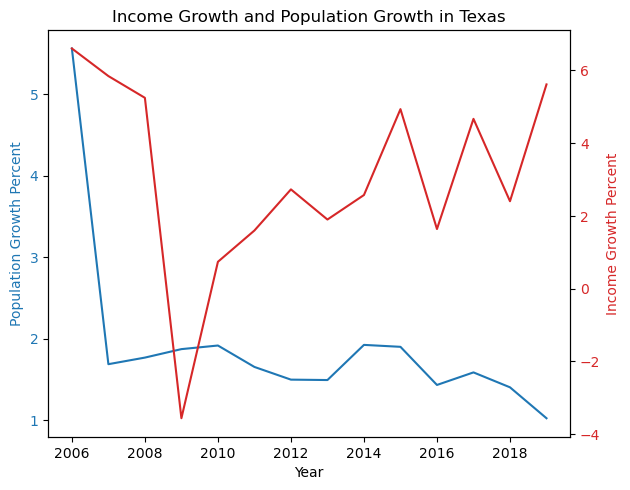

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'income_growth_percent': [None, 6.604333, 5.845688, 5.247329, -3.564934, 0.737686, 1.598272, 2.729187, 1.899882, 2.574269, 4.936363, 1.638726, 4.668965, 2.403473, 5.616124],
    'pop_growth_percent': [None, 5.557292, 1.687088, 1.767852, 1.871700, 1.915932, 1.653265, 1.497670, 1.492716, 1.923629, 1.899903, 1.432452, 1.586356, 1.403479, 1.024450]
}
df = pd.DataFrame(data)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population Growth Percent', color=color)
ax1.plot(df.year, df['pop_growth_percent'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Income Growth Percent', color=color)
ax2.plot(df.year, df['income_growth_percent'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Income Growth and Population Growth in Texas')
plt.show()

##### The population growth rate has decreased over time, whereas the income growth rate has increased over time.